In [4]:
import pandas as pd
import numpy as np
from mxnet import gpu
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

# predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

%load_ext autoreload
%autoreload 2

In [5]:
confirmed = pd.read_csv('raw_data/COVID/time_series_covid19_confirmed_global.csv')
indicators = pd.read_excel('raw_data/SUSTAIN database_08Jan2021_Asia and Latin America.xlsx')
policy = pd.read_excel('raw_data/SUSTAIN database_09Jan2021_policies_Asia and Latin America.xlsx')

In [6]:
# confirmed.head(10)
# len(list(set(policy.entity)))
# len(list(set(indicators.Country)))
# len(list(set(confirmed['Country/Region'])))
countries = list(set(policy.entity).intersection(set(confirmed['Country/Region'])).intersection(set(indicators['Country'])))

In [7]:
# def create_dataset(num_series, num_steps):
    
    
    
    
#     # size = (num_series, num_steps)
    
    
    
    
    

In [8]:
confirmed_series = confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long'],axis=1).loc[countries, :].T

In [9]:
target = StandardScaler().fit_transform(confirmed_series).T
# target = confirmed_series.values.T

In [10]:
covariate_d = np.zeros(target.shape)#np.concatenate((target, target), axis=0)
covariate_d.shape
covariate_d = target

In [11]:
target.shape

(41, 340)

In [12]:
covariate_s = [[0] for _ in range(target.shape[0])]

In [13]:
# define the parameters of the dataset
custom_ds_metadata = {'num_series': len(countries),
                      'num_steps': len(confirmed_series),
                      'prediction_length': 10,
                      'context_length': 10,
                      'freq': '1D',
                      'start': [pd.Timestamp(confirmed_series.index[0], freq='1D')
                                for _ in range(len(confirmed_series))]
                     }

In [14]:
train_ds = ListDataset([{FieldName.TARGET: target,
                         FieldName.START: start,
#                          FieldName.FEAT_STATIC_REAL: fsr,
                         FieldName.FEAT_DYNAMIC_REAL: [fdr],
#                          FieldName.FEAT_STATIC_CAT: fsc
                        }
                        for (target, start, fsr, fdr) in zip(target[:, :-custom_ds_metadata['prediction_length']],
                                                             custom_ds_metadata['start'],
                                                             covariate_s,
                                                             covariate_d[:, :-custom_ds_metadata['prediction_length']],
#                                                              feat_static_cat
                                                            )],
                      freq=custom_ds_metadata['freq'])

test_ds = ListDataset([{FieldName.TARGET: target,
                        FieldName.START: start,
#                         FieldName.FEAT_STATIC_REAL: fsr,
                        FieldName.FEAT_DYNAMIC_REAL: [fdr],
#                          FieldName.FEAT_STATIC_CAT: fsc
                       }
                       for (target, start, fsr, fdr) in zip(target,
                                                  custom_ds_metadata['start'],
                                                  covariate_s,
                                                  covariate_d,
#                                                             feat_static_cat
                                                      )],
                     freq=custom_ds_metadata['freq'])

In [ ]:
# test_series = to_pandas(test_entry)
# train_series = to_pandas(train_entry)

# fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

# train_series.plot(ax=ax[0])
# ax[0].grid(which="both")
# ax[0].legend(["train series"], loc="upper left")

# test_series.plot(ax=ax[1])
# ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
# ax[1].grid(which="both")
# ax[1].legend(["test series", "end of train series"], loc="upper left")

# plt.show()

In [82]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.n_beats import NBEATSEstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.model.seq2seq import MQRNNEstimator, MQCNNEstimator
from gluonts.mx.distribution import StudentTOutput
from gluonts.mx.distribution import GaussianOutput,UniformOutput,NegativeBinomialOutput

# estimator = DeepAREstimator(
# #     num_layers=1,
# #     num_cells=40,
# #     distr_output = NegativeBinomialOutput(),
# #     alpha=0.5,
# #     beta=0.5,
#     prediction_length=custom_ds_metadata['prediction_length'],
# #     context_length=custom_ds_metadata['context_length'],
#     freq=custom_ds_metadata['freq'],
# #     use_feat_dynamic_real=True,
# #     use_feat_static_real=True,
# #     use_feat_static_cat=True,
# #     cardinality=cat_cardinality,
# #     lags_seq=[1],
#     trainer=Trainer(ctx="cpu",#gpu(0),
#                     epochs=10,
#                     learning_rate=1e-3,
#                     num_batches_per_epoch=100,
#                     batch_size=32,
#                    )
# )


from model.simple_feedforward import SimpleFeedForwardEstimator
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[40],
    distr_output = StudentTOutput(),
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(ctx="cpu",#gpu(0),
                    epochs=10,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=32,
                   )
)

# from model.dnn_prob import MyProbEstimator
# from model.dnn_value import MyEstimator
# estimator = MyProbEstimator(
#     prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=custom_ds_metadata['context_length'],
#     freq=custom_ds_metadata['freq'],
#     distr_output = NegativeBinomialOutput(),
#     num_cells=40,
#     scaling=True,
#     trainer=Trainer(ctx="cpu",#gpu(0),
#                     epochs=20,
#                     learning_rate=1e-3,
#                     num_batches_per_epoch=100,
#                     batch_size=32,
#                     hybridize=False, 
#                    )
# )

# from model.rnn import MyProbRNNEstimator
# estimator = MyProbRNNEstimator(
#         prediction_length=custom_ds_metadata['prediction_length'],
#         context_length=custom_ds_metadata['prediction_length'],
#         freq=custom_ds_metadata['freq'],
#         num_cells=40,
#         num_layers=2,
#         distr_output=GaussianOutput(),
#         trainer=Trainer(ctx="cpu",
#                         epochs=5,
#                         learning_rate=1e-3,
#                         hybridize=False,
#                         num_batches_per_epoch=100
#                        )
#     )

In [83]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 193.66it/s, epoch=10/10, avg_epoch_loss=-1.97]


In [84]:
# predictor.serialize(Path("/tmp/"))

In [85]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [86]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [89]:
country_index = 31
ts_entry = tss[country_index]
forecast_entry = forecasts[country_index]

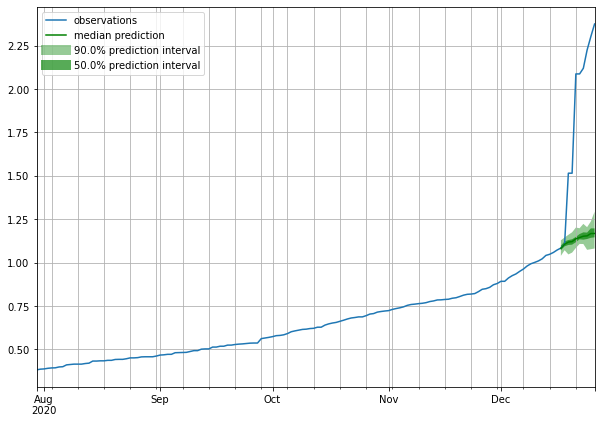

In [90]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
np.array(ts_entry[:5]).reshape(-1,)

In [ ]:
test_ds_entry = next(iter(test_ds))

In [ ]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

In [ ]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

In [ ]:
from gluonts.evaluation import Evaluator
import json

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

In [ ]:
print(json.dumps(agg_metrics, indent=4))

In [ ]:
item_metrics.head()

In [ ]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()